In [1]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# 读取数据

In [3]:
essay_csv = "essay_test.csv"
# 读取数据
#dataframe = pd.read_csv('essays_and_scores.csv', encoding = 'latin-1')

dataframe = pd.read_csv(essay_csv, encoding = 'latin-1')
#copy一份数据
data = dataframe[['id','essay','score']].copy()
#print(data.head(10))
# 查看数据是否有缺失值，可以看出是没有的
#data.info()

## 探索数据

In [4]:
# 转化成dataframe看一下数据是什么样子
pd.DataFrame(data)

id                                              essay  score
0     10001  Dear Jerry. I've heard about that you will giv...   19.5
1     10002  Dear Jerry I'm glad that you'll respresent you...   16.5
2     10003  Dear Jerry, I am very happy to hear that you w...   20.5
3     10004  Dear Je I'm so happy to hear that you will hav...   15.5
4     10005  Dear Jerry, I am so glad to hear that you will...   19.0
...     ...                                                ...    ...
996   11045  Dear Jerry, First, you must know how and what ...   17.5
997   11046                          Dear Jerry, Yours, Li Hua    0.0
998   11047                          Dear Jerry, Yours, Li Hua    0.0
999   11048                          Dear Jerry, Yours, Li Hua    0.0
1000  11049                          Dear Jerry, Yours, Li Hua    0.0

[1001 rows x 3 columns]

In [5]:
#把score列转换为列表
scores = data["score"]
scores = [*scores]
scores
type(scores)

list

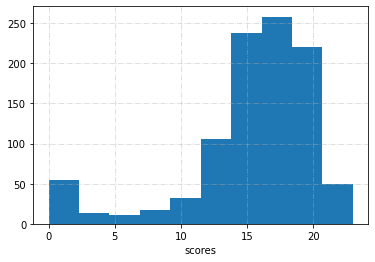

count    1001.000000
mean       15.324176
std         4.992700
min         0.000000
25%        14.000000
50%        16.500000
75%        18.500000
max        23.000000
Name: score, dtype: float64

In [6]:
# 绘制分数分布图& describe数据信息
plt.figure() #初始化一张图
x = scores
plt.hist(x)  #直方图关键操作
plt.grid(alpha=0.5,linestyle='-.') #网格线，更好看 
plt.xlabel('scores')  
plt.show()
data["score"].describe()

# 向量特征

In [7]:
# 统计文章中每篇文章的词频分布
def get_count_vectors(essays):
    # 实例化vectorizer
    '''
    CountVectorizer是属于常见的特征数值计算类，是一个文本特征提取方法。
    # 对于每一个训练文本，它只考虑每种词汇在该训练文本中出现的频率。ngram_range表示词组切分的长度范围
    #设置停用词，设为english将使用内置的英语停用词，设为一个list可自定义停用词,设为None不使用停用词，设为None且max_df∈[0.7, 1.0)将自动根据当前的语料库建立停用词表
    max_features默认为None，可设为int，对所有关键词的term frequency进行降序排序，只取前max_features个作为关键词集
    '''
    vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 3), stop_words='english')
    #fit_transform(X)	拟合模型，并返回文本矩阵
    count_vectors = vectorizer.fit_transform(essays)
    # get_feature_names()	所有文本的词汇；列表型
    feature_names = vectorizer.get_feature_names()
    vocabulary = vectorizer.vocabulary_
    return feature_names, count_vectors,vocabulary

#返回essay的文章的文本矩阵和关键词列表
feature_names_cv, count_vectors,vocabulary = get_count_vectors(data["essay"])

# vocabulary2 = sorted(vocabulary.items(),key = lambda x:x[0])
# print(vocabulary2)

#通过toarray()可看到词频矩阵的结果
'''
这里的x是词频矩阵，类似于以下这种，y 是总得分（也就是使用词频来预测得分）
#[[0 1 1 1]
# [0 2 1 0]
# [1 0 0 1]
# [1 0 0 0]]
'''
# 拿到特征和评分
X_cv = count_vectors.toarray()
y_cv = data["score"].values

# 划分训练集与测试集

In [8]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

# 线性回归与岭回归模型训练

In [9]:
#实例化线性回归

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)
print("测试集准确度：","\n",linear_regressor.score(X_test,y_test))
#print(linear_regressor.score)
# The coefficients
#构建训练集和特征集。利用线性回归和岭回归进行训练，两者差距不大。
print('LinearRegression Coefficients: \n', linear_regressor.coef_)
# The mean squared error
#均方误差，没有开根号
print("LinearRegression Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#绝对值差
#print('LinearRegression MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

测试集准确度： 
 0.4057503513910502
LinearRegression Coefficients: 
 [ 0.13891626  0.2244723  -0.27783535 ... -0.08328568  0.05694957
 -0.06180618]
LinearRegression Mean squared error: 13.35
--------------------------------------------------


In [10]:
#岭回归在多元线性回归的损失函数上加上了正则项，表达为系数 的L2范式（即系数 的平方项）乘以正则化系数，可以看出ridge的结果好一些
ridge = Ridge(alpha=1.0,random_state=100)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("测试集准确度：","\n",ridge.score(X_test,y_test))
print('Ridge Coefficients: \n', ridge.coef_)
print("Ridge Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#print('Ridge MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

测试集准确度： 
 0.42220142527171023
Ridge Coefficients: 
 [ 0.13978696  0.15336255 -0.151187   ... -0.07674654  0.05752454
 -0.05459834]
Ridge Mean squared error: 12.98
--------------------------------------------------


# 尝试其他的语言信息
## 1. 对句子进行分词

In [11]:
example = '''Dear J I am very happy that you will have a English saying for high school students,
           but I think it is difficult, I have some advice hope can help you to do it better. 
           This time, you must prepare for saying, you need to remember what you want to say.
           You must find messages online so that you can finish the job better. 
           It is a practive for you, so you need let it became very important, so that you can treat it better. 
           When you finish the preparement, you have to let you relax, so that you have a result better. 
           When you go on, you not only have mouth, but also have hand, this can help you get better score. 
           In ground, you should do more act with your hands, because it can help you are not embarram.
           Last, when you leave, you should say,  Thanks , then go out politely, Yours,
           '''

In [12]:
def sentence_to_wordlist(raw_sentence):
    #句子清洗
    # re的用法：replacedStr = re.sub("\d+", "222", inputStr)
    clean_sentence = re.sub("[^a-zA-Z0-9]", " ", raw_sentence)# 这里主要是去除除了a-zA-Z0-9之外的字符
    #nltk 分词
    tokens = nltk.word_tokenize(clean_sentence)
    #返回分词的结果
    return tokens

In [13]:
sentence_to_wordlist(example)

['Dear',
 'J',
 'I',
 'am',
 'very',
 'happy',
 'that',
 'you',
 'will',
 'have',
 'a',
 'English',
 'saying',
 'for',
 'high',
 'school',
 'students',
 'but',
 'I',
 'think',
 'it',
 'is',
 'difficult',
 'I',
 'have',
 'some',
 'advice',
 'hope',
 'can',
 'help',
 'you',
 'to',
 'do',
 'it',
 'better',
 'This',
 'time',
 'you',
 'must',
 'prepare',
 'for',
 'saying',
 'you',
 'need',
 'to',
 'remember',
 'what',
 'you',
 'want',
 'to',
 'say',
 'You',
 'must',
 'find',
 'messages',
 'online',
 'so',
 'that',
 'you',
 'can',
 'finish',
 'the',
 'job',
 'better',
 'It',
 'is',
 'a',
 'practive',
 'for',
 'you',
 'so',
 'you',
 'need',
 'let',
 'it',
 'became',
 'very',
 'important',
 'so',
 'that',
 'you',
 'can',
 'treat',
 'it',
 'better',
 'When',
 'you',
 'finish',
 'the',
 'preparement',
 'you',
 'have',
 'to',
 'let',
 'you',
 'relax',
 'so',
 'that',
 'you',
 'have',
 'a',
 'result',
 'better',
 'When',
 'you',
 'go',
 'on',
 'you',
 'not',
 'only',
 'have',
 'mouth',
 'but',
 'a

## 2.先分句，然后按照句子分词

In [14]:
def tokenize(essay):
    # 去掉句子前后空格
    stripped_essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay) # 分句
    #print(raw_sentences)
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    return tokenized_sentences

In [15]:
tokenize(example)

[['Dear',
  'J',
  'I',
  'am',
  'very',
  'happy',
  'that',
  'you',
  'will',
  'have',
  'a',
  'English',
  'saying',
  'for',
  'high',
  'school',
  'students',
  'but',
  'I',
  'think',
  'it',
  'is',
  'difficult',
  'I',
  'have',
  'some',
  'advice',
  'hope',
  'can',
  'help',
  'you',
  'to',
  'do',
  'it',
  'better'],
 ['This',
  'time',
  'you',
  'must',
  'prepare',
  'for',
  'saying',
  'you',
  'need',
  'to',
  'remember',
  'what',
  'you',
  'want',
  'to',
  'say'],
 ['You',
  'must',
  'find',
  'messages',
  'online',
  'so',
  'that',
  'you',
  'can',
  'finish',
  'the',
  'job',
  'better'],
 ['It',
  'is',
  'a',
  'practive',
  'for',
  'you',
  'so',
  'you',
  'need',
  'let',
  'it',
  'became',
  'very',
  'important',
  'so',
  'that',
  'you',
  'can',
  'treat',
  'it',
  'better'],
 ['When',
  'you',
  'finish',
  'the',
  'preparement',
  'you',
  'have',
  'to',
  'let',
  'you',
  'relax',
  'so',
  'that',
  'you',
  'have',
  'a',
  '

## 3.每个单词平均有几个字母
## 输入essay，返回每个单词平均有几个字母

In [16]:
def avg_word_len(essay):
    # 清洗文章
    clean_essay = re.sub(r'\W', ' ', essay)
    # 分词
    words = nltk.word_tokenize(clean_essay)
    # 遍历word，然后把每一个word的单词数目相加，然后除以总的单词数目，即可得到 每个单词平均有几个字母
    return sum(len(word) for word in words) / len(words)

In [17]:
 avg_word_len(example)

3.896103896103896

## 4.文章单词总数

In [18]:
def word_count(essay):
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    return len(words)

In [19]:
word_count(example)

154

## 5.文章字母总数

In [20]:
def char_count(essay):
    # 删除空格即返回文章字母总数
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    return len(clean_essay)

In [21]:
char_count(example)

626

## 6.文章句子总数

In [22]:
def sent_count(essay):
    sentences = nltk.sent_tokenize(essay)
    return len(sentences)

In [23]:
sent_count(example)

8

## 7.统计词形还原后的单词总数,也就是总共有多少不同的单词-词汇丰富度

In [24]:
def count_lemmas(essay):
    #分句
    tokenized_sentences = tokenize(essay)
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        #print(tagged_tokens)
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            if pos_tag.startswith('N'):
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
                #print(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    lemma_count = len(set(lemmas))
    # print(lemma_count)
    return lemma_count

In [25]:
count_lemmas(example)

84

In [26]:
# tokenized_sentences = tokenize(example)
# wordnet_lemmatizer = WordNetLemmatizer()

# for sentence in tokenized_sentences:
#     tagged_tokens = nltk.pos_tag(sentence)
#     print(tagged_tokens)

## 8.文章中错误单词总数

In [27]:
def count_spell_error(essay):
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)

    # big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()

    words_ = re.findall('[a-z]+', data.lower())


    word_dict = collections.defaultdict(lambda: 0)

    for word in words_:
        word_dict[word] += 1

    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)

    mispell_count = 0

    words = clean_essay.split()

    for word in words:
        # 如果essay中的词汇不在big data 这个文件下，那么就认为这个单词拼写错了
        if not word in word_dict:
            mispell_count += 1

    return mispell_count

In [28]:
count_spell_error(example)

3

## 9.统计名词，动词，形容词和副词的数量

In [29]:
def count_pos(essay):
    tokenized_sentences = tokenize(essay)

    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)

        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]

            if pos_tag.startswith('N'):
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1

    return noun_count, adj_count, verb_count, adv_count

In [30]:
count_pos(example)

(18, 11, 40, 14)

## 10.统计文章中每篇文章的词频-文本向量

In [31]:
def get_count_vectors(essays):
    vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 3), stop_words='english')

    count_vectors = vectorizer.fit_transform(essays)

    feature_names = vectorizer.get_feature_names()

    return feature_names, count_vectors

## 11. 统计文章中连词的个数

In [32]:
def count_conj(essay):
    tokenized_sentences = tokenize(essay)

    conj_count = 0
    ps_conj = 0

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)

        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            
            if pos_tag.startswith('C'):
                conj_count += 1
            if pos_tag.startswith("IN"):
                ps_conj += 1
    return conj_count,ps_conj

In [33]:
count_conj(example)

(2, 12)

## 一个总的函数，构建文章的特征 输入的 data 就是essay

In [34]:
def extract_features(data):
    features = data.copy()

    features['char_count'] = features['essay'].apply(char_count) #文章字母总数
    features['word_count'] = features['essay'].apply(word_count) #文章单词总数
    features['sent_count'] = features['essay'].apply(sent_count) #文章句子总数
    features['avg_word_len'] = features['essay'].apply(avg_word_len) #平均单词长度
    features['lemma_count'] = features['essay'].apply(count_lemmas) # 文章词性统计
    features['spell_err_count'] = features['essay'].apply(count_spell_error) # 文章写错的单词总数
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(
        *features['essay'].map(count_pos)) # 文章名词  动词 形容词 副词的总数
    features["conj"], features["ps_conj"] = zip(*features["essay"].map(count_conj)) #连词的总数
    return features

#拿到特征
features = extract_features(data)
#print(features.columns)

## 绘制散点图 表示各向量与score的关系

<AxesSubplot:xlabel='ps_conj', ylabel='score'>

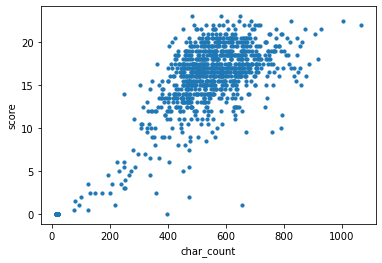

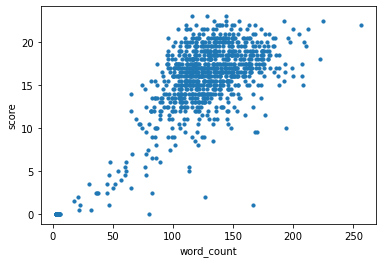

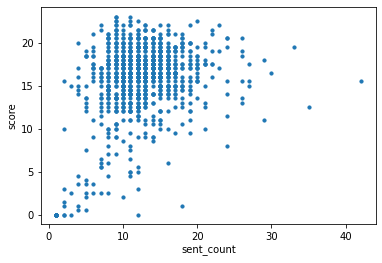

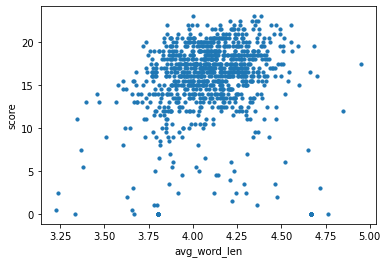

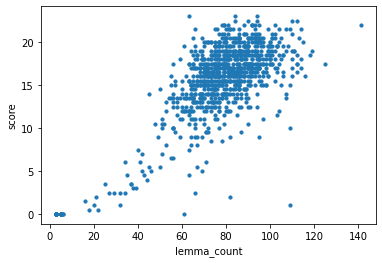

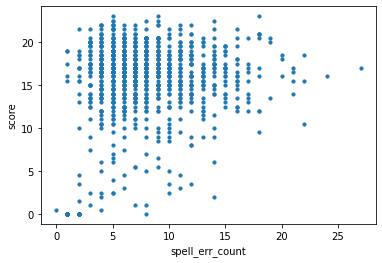

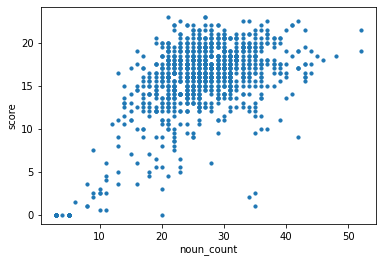

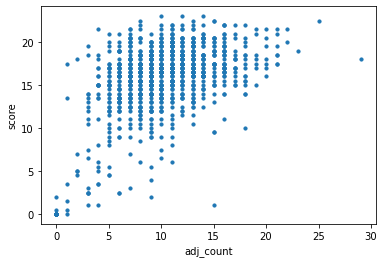

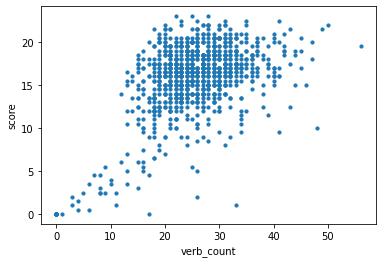

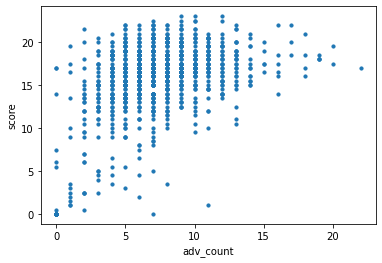

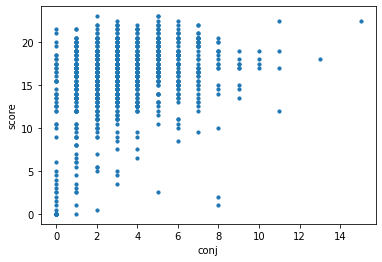

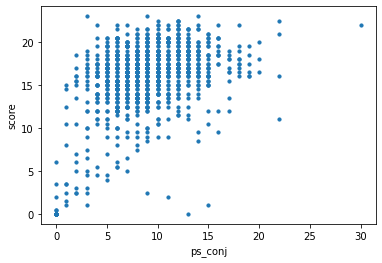

In [182]:
# 参数s表示散点的面积
features.plot.scatter(x = 'char_count', y = 'score', s=10)
features.plot.scatter(x = 'word_count', y = 'score', s=10)
features.plot.scatter(x = 'sent_count', y = 'score', s=10)
features.plot.scatter(x = 'avg_word_len', y = 'score', s=10)
features.plot.scatter(x = 'lemma_count', y = 'score', s=10)
features.plot.scatter(x = 'spell_err_count', y = 'score', s=10)
features.plot.scatter(x = 'noun_count', y = 'score', s=10)
features.plot.scatter(x = 'adj_count', y = 'score', s=10)
features.plot.scatter(x = 'verb_count', y = 'score', s=10)
features.plot.scatter(x = 'adv_count', y = 'score', s=10)
features.plot.scatter(x = 'conj', y = 'score', s=10)
features.plot.scatter(x = 'ps_conj', y = 'score', s=10)

## 计算特征与y之间的spearman 相关系数

In [35]:
n = len(features['char_count'] )
scores = features["score"]
char_count = features['char_count'].corr(scores,method="spearman")
word_count = features['word_count'].corr(scores,method="spearman")
sent_count = features['sent_count'].corr(scores,method="spearman")
avg_word_len = features['avg_word_len'].corr(scores,method="spearman")
lemma_count = features['lemma_count'].corr(scores,method="spearman")
spell_err_count = features['spell_err_count'].corr(scores,method="spearman")
noun_count =  features['noun_count'].corr(scores,method="spearman")
adj_count = features['adj_count'].corr(scores,method="spearman")
verb_count = features['verb_count'].corr(scores,method="spearman")
adv_count = features['adv_count'].corr(scores,method="spearman")
conj_count =  features["conj"].corr(scores,method="spearman")
ps_conj_count = features["ps_conj"].corr(scores,method="spearman")

In [36]:
# 封装成字典并按照value 排序
spearman_dic = {
    "char_count":char_count
    ,"word_count":word_count
    ,"sent_count":sent_count
    ,"avg_word_len":avg_word_len
    ,"lemma_count":lemma_count
    ,"spell_err_count":spell_err_count
    ,"noun_count":noun_count
    ,"adj_count":adj_count
    ,"verb_count":verb_count
    ,"adv_count":adv_count
    ,"conj_count":conj_count
    ,"ps_conj_count":ps_conj_count
}
a = sorted(spearman_dic.items(), key=lambda x: x[1], reverse=True)
for item in a:
    print(item)
# 排序可知,词汇丰富度/作文长度 对作文评分影响最重要，其次是形容词、名词、连词与动词的使用。

('lemma_count', 0.5900492618967987)
('char_count', 0.5610447020419941)
('word_count', 0.5162290403183958)
('adj_count', 0.4643060472605979)
('noun_count', 0.4531868654788258)
('ps_conj_count', 0.42338742019373443)
('adv_count', 0.42173414625123656)
('verb_count', 0.4101569091689511)
('conj_count', 0.35465992148936676)
('sent_count', 0.26635519193646884)
('avg_word_len', 0.2290709317896946)
('spell_err_count', 0.10274870757647674)


In [37]:
#删除相关度0.3以下的数据
processed_features = features.drop(["avg_word_len","sent_count","essay","id"],axis=1)

In [38]:
processed_features.head()

score  char_count  word_count  lemma_count  spell_err_count  noun_count  \
0   19.5         513         119           88                5          27   
1   16.5         616         137           88                6          28   
2   20.5         676         164           93                4          30   
3   15.5         555         130           79                7          26   
4   19.0         657         150           89               15          32   

   adj_count  verb_count  adv_count  conj  ps_conj  
0          7          26          9     2        8  
1         11          27          9     4       14  
2         15          33         11     7       15  
3         10          23         13     4        8  
4         10          28         12     6       13

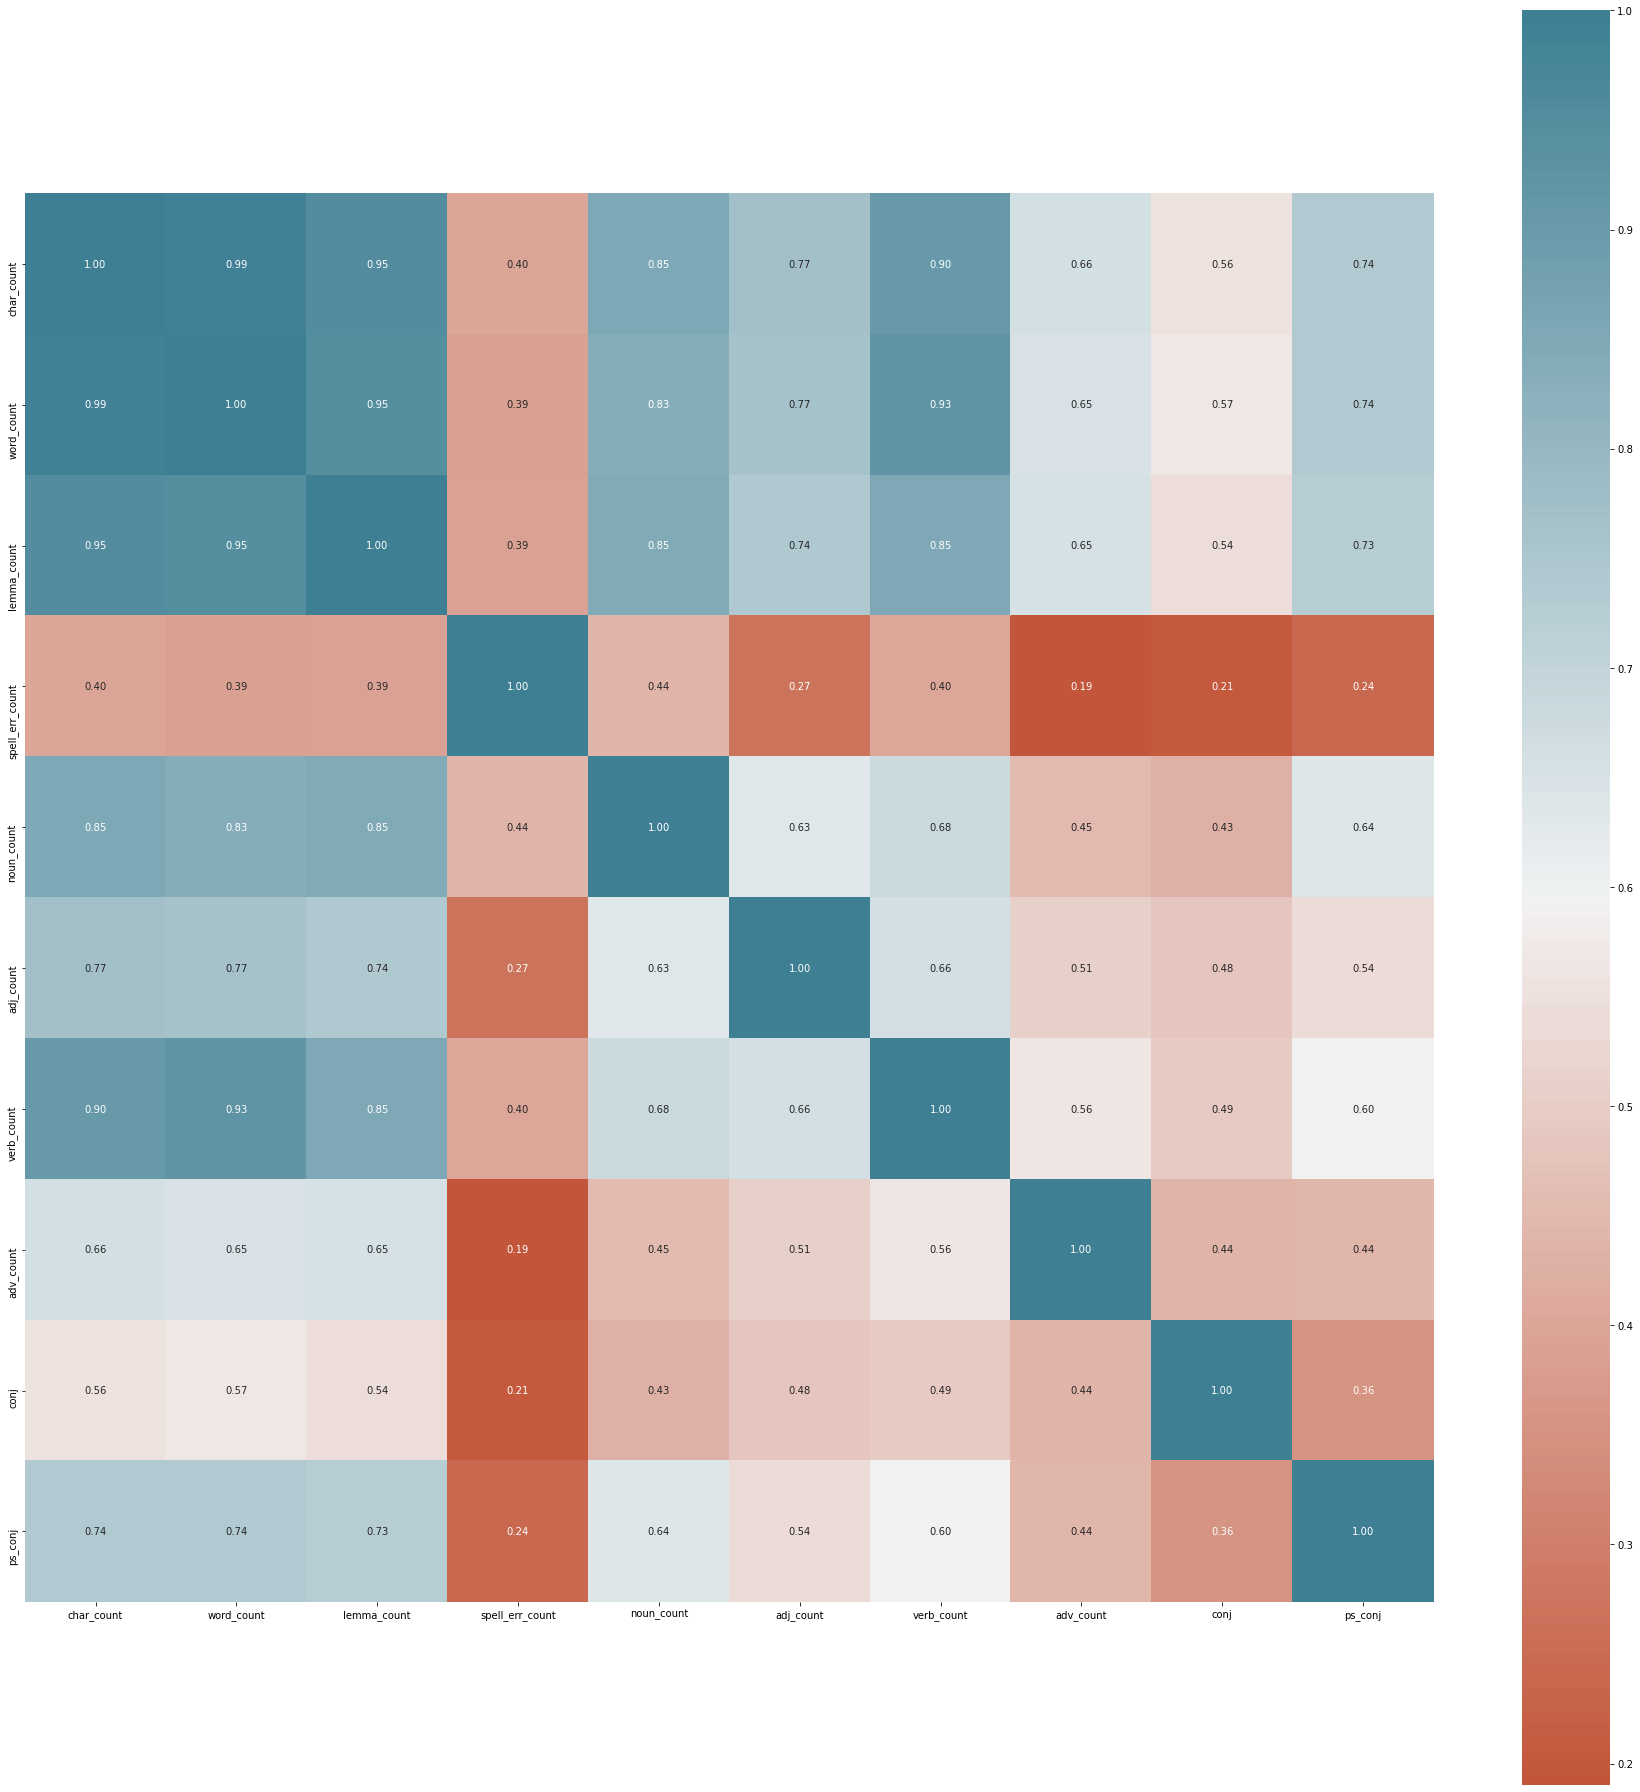

In [39]:
# 计算特征与特征之间的皮尔森系数，画热力图
import seaborn as sns
plt.figure(figsize = (25,25))
corr_values = processed_features.iloc[:,1:].corr() # pandas直接调用corr就能计算特征之间的相关系数
#遮住上半部分
mask = np.zeros_like(corr_values, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 绘制热力图
sns.heatmap(corr_values, annot=True,vmax=1, square=True, cmap=sns.diverging_palette(20, 220, n=200),fmt='.2f',xticklabels=True, yticklabels=True)
plt.tight_layout()
# plt.savefig('prepare_data/columns37.png',dpi=600)
plt.show()

##  数据标准化-使用standardscaler

In [40]:
from sklearn.preprocessing import StandardScaler
X = processed_features.iloc[:,1:].values
y = processed_features["score"].values
scaler = StandardScaler() #实例化
scaler.fit(X) #fit，本质是生成均值和方差
scaler.mean_ #查看均值的属性mean_
scaler.var_ #查看方差的属性var_

array([2.71804079e+04, 1.49315496e+03, 4.62845151e+02, 1.67870870e+01,
       6.35621402e+01, 1.96189525e+01, 7.47426380e+01, 1.29950948e+01,
       4.89634042e+00, 1.78926628e+01])

In [41]:
X_new = scaler.fit_transform(X) #使用fit_transform(data)一步达成结果
#scaler.inverse_transform(x_std) #使用inverse_transform逆转标准化

In [42]:
X_new

array([[-0.08215492, -0.10734228,  0.54338564, ...,  0.52210409,
        -0.54311994, -0.15752673],
       [ 0.54259936,  0.35847979,  0.54338564, ...,  0.52210409,
         0.36072555,  1.26092239],
       [ 0.90653389,  1.0572129 ,  0.77579421, ...,  1.07690897,
         1.71649377,  1.49733057],
       ...,
       [-3.06641808, -3.05754875, -3.31459668, ..., -1.97451785,
        -1.44696543, -2.04879223],
       [-3.06641808, -3.05754875, -3.31459668, ..., -1.97451785,
        -1.44696543, -2.04879223],
       [-3.06641808, -3.05754875, -3.31459668, ..., -1.97451785,
        -1.44696543, -2.04879223]])

## 构建新的特征矩阵（把原来的向量和他连在一起）

In [43]:
X = np.concatenate((X_new, X_cv), axis = 1)
y = y

## 划分训练集与测试集

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## 线性回归

In [45]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)

# The coefficients 表示每一个特征所占的权重
print("测试集得分：\n",linear_regressor.score(X_test,y_test))
print('LinearRegression Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print("LinearRegression Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# 平均绝对百分比误差（Mean Absolute Percentage Error）
#print('LinearRegression MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print("R2:%f"% r2_score(y_test, y_pred))
print('-' * 50)

测试集得分：
 0.5826263252250543
LinearRegression Coefficients: 
 [ 4.36545172e-02  2.44804532e+00  2.09207248e+00 ... -9.48924327e-04
  2.58614290e-02  8.11534189e-02]
LinearRegression Mean squared error: 10.32
R2:0.582626
--------------------------------------------------


## 岭回归

In [46]:
alpha = 200
ridge = Ridge(alpha=alpha)# 正则项的程度
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print("测试集得分：\n {0}".format(ridge.score(X_test,y_test)))
print('Ridge Coefficients: \n', ridge.coef_)
print("Ridge Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R2:%f"% r2_score(y_test, y_pred))
#print('Ridge MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

测试集得分：
 0.6296487860040489
Ridge Coefficients: 
 [ 0.59313596  0.48631253  1.11376315 ... -0.00515962  0.00607232
  0.00862623]
Ridge Mean squared error: 9.16
R2:0.629649
--------------------------------------------------


## 网格搜索-岭回归

In [47]:
ridge_ = Ridge()
# 网格搜索  找到最佳的alpha值，也就是最佳的正则项系数
param_alpha = {'alpha': range(10,60,1)}
#传入模型和参数
grid = GridSearchCV(estimator=ridge_, param_grid=param_alpha) # 网格搜索同时满足了fit，search 和score 的三种功能
# 网格搜索会从参数中不断选取对应的参数进行组合，然后自动进行交叉验证，返回每一组参数下交叉验证的
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
#输出最佳结果
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

print("测试集最佳得分：\n",grid.best_score_)
print("Grid Ridge Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#print('Grid Ridge MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

#-------------------绘制学习曲线------------------------#

0.6536445329009712
Ridge(alpha=59)
{'alpha': 59}
测试集最佳得分：
 0.6536445329009712
Grid Ridge Mean squared error: 9.04
--------------------------------------------------


## 网格搜索 -GBDT算法

In [75]:
params = {'n_estimators':[100, 1000], 'max_depth':[2], 'min_samples_split': [2], 'learning_rate':[3, 1, 0.1, 0.3], 'loss': ['ls']}
gbdt = ensemble.GradientBoostingRegressor()
grid = GridSearchCV(estimator=gbdt,param_grid=params)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

print("测试集最佳得分：\n",grid.best_score_)
print("Grid GBDT Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Grid GBDT Variance score: %.2f' % ridge.score(X_test, y_test))
print('Grid GBDT MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sam

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sam

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return uf

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
D:\Program\anaconda\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered

KeyboardInterrupt: 

## 网格搜索- 随机森林算法

In [50]:
%%time
rf = ensemble.RandomForestRegressor()
params = {'n_estimators': range(50,70,1), 'max_depth':[10, 50, 100], 'max_features':[2, 5, 10]}
grid = GridSearchCV(estimator=rf, param_grid=params)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

print("测试集最佳得分：\n",grid.best_score_)
print("Grid RF Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Grid RF Variance score: %.2f' % ridge.score(X_test, y_test))
print('Grid RF MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

0.684059164138964
RandomForestRegressor(max_depth=100, max_features=10, n_estimators=62)
{'max_depth': 100, 'max_features': 10, 'n_estimators': 62}
测试集最佳得分：
 0.684059164138964
Grid RF Mean squared error: 9.10
Grid RF Variance score: 0.63
Grid RF MAPE:inf
--------------------------------------------------
Wall time: 4min 52s


<timed exec>:13: RuntimeWarning: divide by zero encountered in true_divide


## 网格搜索xboost 算法

In [51]:
%%time
model = xgb.XGBRegressor()
params = {'n_estimators': [100, 150, 160], 'learning_rate': [0.1, 0.5, 1.0]}
grid = GridSearchCV(estimator=model, param_grid=params)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print("测试集最佳得分：\n",grid.best_score_)
print("Grid xgboost Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Grid xgboost MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

测试集最佳得分：
 0.7344704647193986
Grid xgboost Mean squared error: 7.46
Grid xgboost MAPE:inf
--------------------------------------------------
Wall time: 14min 37s


<timed exec>:8: RuntimeWarning: divide by zero encountered in true_divide
